In [1]:
import awkward as ak
import pandas as pd
import numpy as np
import vector
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema, DelphesSchema
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import DM_HEP_AN as dm
from math import pi
hep.style.use("CMS")

In [2]:
#BM = 'BK2'
BM = 2

#Set the number of jets you want to take into account in your analysis
n_jets = 6
n_lep = 2

if BM == "BK2":
    fname = "/cms/Tomas/VBF_DM_Background/Pp2DYPlusJets_VBF_Background/Events/run_01/tag_1_delphes_events.root"
    x_sec = 124.8 * 1e-12
if BM == 2:
    fname = "/cms/mc/MG5_aMC_v3_1_1/PP2VBF_DM_Tomas/Events/run_03/tag_1_delphes_events.root"
    x_sec = 0.000936013104099 * 1e-12

tree_test = dm.Converter(fname)
tree_test.generate(jet_elements = n_jets, e_mu_elements = n_lep)
df = tree_test.df

In [3]:
df.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_eta0,jet_eta1,jet_eta2,jet_eta3,...,electron_pt0,electron_pt1,electron_eta0,electron_eta1,electron_phi0,electron_phi1,electron_charge0,electron_charge1,missinget_met,missinget_phi
0,292.171875,195.432251,163.513824,55.263786,37.525898,22.180052,-0.414044,-1.113965,-0.662382,-1.363229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,537.019226,-1.008749
1,296.361389,39.507797,NaN,NaN,NaN,NaN,1.233901,2.273527,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.071503,-0.255981
2,253.279999,81.050690,48.958035,40.101448,NaN,NaN,-0.585476,-0.303560,2.033891,0.210756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.731079,-0.104071
3,51.352203,27.688314,27.670570,27.228874,NaN,NaN,0.853600,3.269217,1.099087,2.303544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.319714,-2.616674
4,104.275429,52.465309,32.925106,27.387445,NaN,NaN,0.258191,0.567820,2.092868,1.713002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.491684,-0.992771


In [4]:
df_cut = df.query('missinget_met > 250 &\
                   jet_pt0 > 60 &\
                   jet_pt1 > 60 &\
                   abs(jet_eta0) < 5 &\
                   abs(jet_eta1) < 5').copy()

In [5]:
df_cut['n_taus'] = df_cut.apply(dm.veto_tag, axis = 1, args = ["tau", n_jets])
df_cut['n_bs'] = df_cut.apply(dm.veto_tag, axis = 1, args = ["b", n_jets])
df_cut['n_ele'] = df_cut.apply(dm.veto_tag, axis = 1, args = ["electron", n_lep])
df_cut['n_mu'] = df_cut.apply(dm.veto_tag, axis = 1, args = ["muon", n_lep])

In [6]:
df_cut = df_cut[df_cut['n_taus'] < 1]
df_cut = df_cut[df_cut['n_bs'] < 1]
df_cut = df_cut[df_cut['n_ele'] < 1]
df_cut = df_cut[df_cut['n_mu'] < 1]

In [7]:
def get_vectorial_HT(row):
    H_T = vector.obj(pt = 0,
                     phi = 0,
                     eta = 0,
                     mass = 0)
    for i in range(n_jets):
        jet_i = vector.obj(pt = row.loc[f'jet_pt{i}'],
                           phi = row.loc[f'jet_phi{i}'],
                           eta = row.loc[f'jet_eta{i}'],
                           mass = row.loc[f'jet_mass{i}'])
        if jet_i.pt > 20 and  np.abs(jet_i.eta) < 5:
            H_T = H_T + jet_i
    
    return H_T.pt

def get_min_Delta_Phi_jet_met(row):
    dphi_min = 10
    met_phi = row['missinget_phi']
    
    for i in range(n_jets):
        dphi = row[f'jet_phi{i}'] - met_phi
    
        if dphi >= np.pi: 
            dphi -= 2*np.pi
        if dphi < -np.pi:
            dphi += 2*np.pi
            
        if dphi < dphi_min:
            dphi_min = dphi 

    return np.abs(dphi_min)

def dijet_mass(row):
    j1 = vector.obj(pt = row.loc[f'jet_pt0'],
                    phi = row.loc[f'jet_phi0'],
                    eta = row.loc[f'jet_eta0'],
                    mass = row.loc[f'jet_mass0'])
    j2 = vector.obj(pt = row.loc[f'jet_pt1'],
                    phi = row.loc[f'jet_phi1'],
                    eta = row.loc[f'jet_eta1'],
                    mass = row.loc[f'jet_mass1'])
    
    return (j1 + j2).mass


In [8]:
df_cut['H_T_vect'] = df_cut.apply(get_vectorial_HT, axis = 1)
df_cut = df_cut[df_cut['H_T_vect'] > 120]
df_cut

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_eta0,jet_eta1,jet_eta2,jet_eta3,...,electron_phi1,electron_charge0,electron_charge1,missinget_met,missinget_phi,n_taus,n_bs,n_ele,n_mu,H_T_vect
0,292.171875,195.432251,163.513824,55.263786,37.525898,22.180052,-0.414044,-1.113965,-0.662382,-1.363229,...,NaN,NaN,NaN,537.019226,-1.008749,0,0,0,0,555.030040
2,253.279999,81.050690,48.958035,40.101448,NaN,NaN,-0.585476,-0.303560,2.033891,0.210756,...,NaN,NaN,NaN,320.731079,-0.104071,0,0,0,0,319.070330
6,289.513763,71.483475,46.497452,NaN,NaN,NaN,2.087888,1.627609,-3.874460,NaN,...,NaN,NaN,NaN,262.119049,1.623779,0,0,0,0,294.337199
9,198.039291,75.861908,69.434303,58.693264,32.377480,NaN,-1.029675,-0.459594,0.464999,2.638504,...,NaN,NaN,NaN,272.051788,-0.505385,0,0,0,0,277.004545
16,294.589600,67.804001,NaN,NaN,NaN,NaN,1.164963,1.728412,NaN,NaN,...,NaN,NaN,NaN,381.033325,-2.112911,0,0,0,0,357.440785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,430.413788,159.627670,37.205387,32.585995,NaN,NaN,0.062702,1.195399,-1.206143,-2.429861,...,NaN,NaN,NaN,350.731171,-1.486525,0,0,0,0,345.828358
99984,279.084625,72.216171,NaN,NaN,NaN,NaN,-0.931360,1.398582,NaN,NaN,...,NaN,NaN,NaN,376.423981,-0.166761,0,0,0,0,350.401950
99993,434.461334,92.808136,75.795471,31.632607,NaN,NaN,-0.314478,1.248570,0.926380,1.493414,...,NaN,NaN,NaN,539.304504,-1.207257,0,0,0,0,497.691112
99997,260.788452,67.785179,37.663197,NaN,NaN,NaN,0.866389,1.457111,-2.774904,NaN,...,NaN,NaN,NaN,324.367126,-1.432365,0,0,0,0,348.050568


In [9]:
df_cut['min_Delta_phi_jets_met'] = df_cut.apply(get_min_Delta_Phi_jet_met, axis = 1)
df_cut = df_cut[df_cut['min_Delta_phi_jets_met'] > 0.5]

In [10]:
df_cut

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_eta0,jet_eta1,jet_eta2,jet_eta3,...,electron_charge0,electron_charge1,missinget_met,missinget_phi,n_taus,n_bs,n_ele,n_mu,H_T_vect,min_Delta_phi_jets_met
0,292.171875,195.432251,163.513824,55.263786,37.525898,22.180052,-0.414044,-1.113965,-0.662382,-1.363229,...,NaN,NaN,537.019226,-1.008749,0,0,0,0,555.030040,2.493037
2,253.279999,81.050690,48.958035,40.101448,NaN,NaN,-0.585476,-0.303560,2.033891,0.210756,...,NaN,NaN,320.731079,-0.104071,0,0,0,0,319.070330,2.604918
6,289.513763,71.483475,46.497452,NaN,NaN,NaN,2.087888,1.627609,-3.874460,NaN,...,NaN,NaN,262.119049,1.623779,0,0,0,0,294.337199,2.443608
9,198.039291,75.861908,69.434303,58.693264,32.377480,NaN,-1.029675,-0.459594,0.464999,2.638504,...,NaN,NaN,272.051788,-0.505385,0,0,0,0,277.004545,2.853776
16,294.589600,67.804001,NaN,NaN,NaN,NaN,1.164963,1.728412,NaN,NaN,...,NaN,NaN,381.033325,-2.112911,0,0,0,0,357.440785,2.812514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,430.413788,159.627670,37.205387,32.585995,NaN,NaN,0.062702,1.195399,-1.206143,-2.429861,...,NaN,NaN,350.731171,-1.486525,0,0,0,0,345.828358,3.104335
99984,279.084625,72.216171,NaN,NaN,NaN,NaN,-0.931360,1.398582,NaN,NaN,...,NaN,NaN,376.423981,-0.166761,0,0,0,0,350.401950,3.064467
99993,434.461334,92.808136,75.795471,31.632607,NaN,NaN,-0.314478,1.248570,0.926380,1.493414,...,NaN,NaN,539.304504,-1.207257,0,0,0,0,497.691112,1.467613
99997,260.788452,67.785179,37.663197,NaN,NaN,NaN,0.866389,1.457111,-2.774904,NaN,...,NaN,NaN,324.367126,-1.432365,0,0,0,0,348.050568,2.963504


In [11]:
df_cut["dijet_mass"] = df_cut.apply(dijet_mass, axis = 1)

df_cut.query('dijet_mass > 1000', inplace = True)

/tmp/ipykernel_3073034/1809991452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut["dijet_mass"] = df_cut.apply(dijet_mass, axis = 1)
/tmp/ipykernel_3073034/1809991452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.query('dijet_mass > 1000', inplace = True)


In [12]:
df_cut['delta_eta_jj'] = np.abs(df_cut['jet_eta0'] - df_cut['jet_eta1'])
df_cut.query('delta_eta_jj > 3.8 &\
              jet_eta0 * jet_eta1 < 0', inplace = True)

/tmp/ipykernel_3073034/1181859498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['delta_eta_jj'] = np.abs(df_cut['jet_eta0'] - df_cut['jet_eta1'])
/tmp/ipykernel_3073034/1181859498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.query('delta_eta_jj > 3.8 &\


In [13]:
if BM == "bkg":
    Luminosity = 35.9
else:
    Luminosity = 35.9
n_mc_ev = df.shape[0]
n_ex_ev = x_sec * Luminosity / (1e-15)
w = n_ex_ev / n_mc_ev
w

0.00033602870437154095

In [14]:
df_cut.shape[0] * w 

0.12533870673058478

In [15]:
bines = [i for i in range(1000, 2900, 200)] + [3200, 3800, 5000]
bines

[1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3200, 3800, 5000]

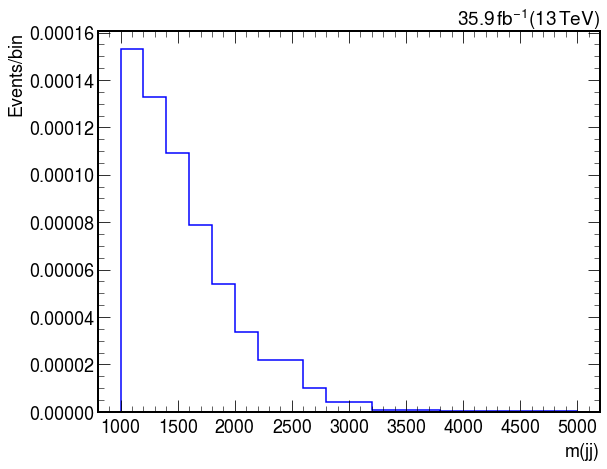

In [35]:
bines = [i for i in range(1000, 2900, 200)] + [3200, 3800, 5000]
h1, binss1 = np.histogram(df_cut.dijet_mass, bines)
counts = h1 * w


labs_sizes = 18
f, axs = plt.subplots( figsize=(9, 7))
hep.histplot(h1 * w / [200, 200,
                       200, 200,
                       200, 200,
                       200, 200, 
                       200, 400,
                       600, 1200],
             bins = binss1,
             ax=axs, 
             histtype= 'step' ,
             #yerr= h1 ** 0.5 * w, 
             color = 'blue'
            );
axs.set_xlabel("$m(jj)$", fontsize = labs_sizes)
axs.set_ylabel('Events/bin',fontsize = labs_sizes)
#axs.set_yscale("log")
#axs.legend(fontsize = labs_sizes - 6 , loc = 'best')
axs.xaxis.set_tick_params(labelsize= labs_sizes)
axs.yaxis.set_tick_params(labelsize= labs_sizes)
axs.set_title(r'$35.9 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
plt.savefig("Dijet_mass_VBF");

Pedir a Daniel el banner de la producción de su artículo, y reproducir cualquiera de los puntos de mediador vectorial (spin1)

In [28]:
counts, di_jet_mass = np.histogram(df_cut.dijet_mass, bines)
counts = h1 * w / [200, 200,
                   200, 200,
                   200, 200,
                   200, 200, 
                   200, 400,
                   600, 1200]
di_missing_et = {f"{di_jet_mass[i]} - {di_jet_mass[i+1]}" :
                 counts[i] for i in range(len(bines)-1)}

di_missing_et

{'1000 - 1200': 0.00015289306048905113,
 '1200 - 1400': 0.00013273133822675867,
 '1400 - 1600': 0.00010920932892075082,
 '1600 - 1800': 7.896674552731213e-05,
 '1800 - 2000': 5.376459269944655e-05,
 '2000 - 2200': 3.36028704371541e-05,
 '2200 - 2400': 2.1841865784150162e-05,
 '2400 - 2600': 2.1841865784150162e-05,
 '2600 - 2800': 1.0080861131146227e-05,
 '2800 - 3200': 4.200358804644262e-06,
 '3200 - 3800': 5.600478406192349e-07,
 '3800 - 5000': 2.8002392030961746e-07}

In [29]:
df_jessica = pd.DataFrame(data = [di_missing_et.keys(), di_missing_et.values()]).T
df_jessica

,0,1
0,1000 - 1200,0.000153
1,1200 - 1400,0.000133
2,1400 - 1600,0.000109
3,1600 - 1800,0.000079
4,1800 - 2000,0.000054
5,2000 - 2200,0.000034
6,2200 - 2400,0.000022
7,2400 - 2600,0.000022
8,2600 - 2800,0.00001
9,2800 - 3200,0.000004


In [30]:
df_jessica.columns = ["bins", "Events/bin"]
df_jessica['bins_lower'] = bines[:-1]
df_jessica.to_csv(f'dijet_mass_VBF_BM{BM}.csv')